# LSTM based Sentiment Prediction and Recommender

## This notebook is divided into three parts as shown below:
### 1. Recommenders- Collaborative Filtering (Unsupervised and Supervised KNN).
### 2. LSTM Sentiment Prediction.
### 3. Recommenders- Content-Based Recommender.

#### Import libraries

In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,recall_score,precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error
from math import sqrt
from nltk.corpus import stopwords


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AX4XfWgoPOoT1FhZYHDaTnPkwJ213VCk0QQNNQ3xMMOJgH9g5ap0hoylM8Y
Mounted at /content/drive


# 1. Recommenders (Collaborative Filtering using KNN)

---



In [ ]:
#Taking 1st 200k data from Amazon data set for training and validation purposes
data500=pd.read_json('/content/drive/MyDrive/Appliances.json/Appliances.json',lines=True)

In [ ]:
data500.columns

Index(['overall', 'vote', 'verified', 'reviewTime', 'reviewerID', 'asin',
       'style', 'reviewerName', 'reviewText', 'summary', 'unixReviewTime',
       'image'],
      dtype='object')

In [ ]:
data500.shape

(602777, 12)

In [ ]:
print(f"Number of unique products in the dataset:{len(data500.asin.unique())}")

Number of unique products in the dataset:30252


In [ ]:
print(f"Number of unique users in the dataset:{len(data500.reviewerID.unique())}")

Number of unique users in the dataset:515650


In [ ]:
#create dfs to obtain number of reviews and average ratings per product
count = data500.groupby("asin", as_index=False).count()
mean = data500.groupby("asin", as_index=False).mean()
#merge
dfMerged = pd.merge(data500, count, how='right', on=['asin'])

In [ ]:
count.head()

asin  overall  vote  ...  summary  unixReviewTime  image
0  1118461304       45     8  ...       45              45      0
1  1906487049        3     0  ...        3               3      0
2  6040985461        1     0  ...        1               1      0
3  7301113188        1     0  ...        1               1      0
4  7861850250        1     0  ...        1               1      0

[5 rows x 12 columns]

In [ ]:
count.shape

(30252, 12)

In [ ]:
mean.head()

asin   overall  verified  unixReviewTime
0  1118461304  4.600000  0.155556    1.395790e+09
1  1906487049  4.666667  1.000000    1.371139e+09
2  6040985461  5.000000  1.000000    1.440029e+09
3  7301113188  5.000000  1.000000    1.236902e+09
4  7861850250  3.000000  1.000000    1.484352e+09

In [ ]:
mean.shape

(30252, 4)

In [ ]:
mean=mean.rename(columns={'asin': 'productID'})

In [ ]:
dfMerged.shape

(602777, 23)

In [ ]:
dfMerged.head()

overall_x vote_x  verified_x  ... summary_y unixReviewTime_y image_y
0          5      2       False  ...        45               45       0
1          5    NaN       False  ...        45               45       0
2          5    NaN       False  ...        45               45       0
3          5    NaN       False  ...        45               45       0
4          5     10       False  ...        45               45       0

[5 rows x 23 columns]

In [ ]:
#rename column
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]
dfMerged["UserID"]=dfMerged['reviewerName_x']
dfNew = dfMerged[['asin','UserID','summaryReview','overallScore',"totalReviewers"]]


In [ ]:
dfNew.head()

asin                    UserID  ... overallScore  totalReviewers
0  1118461304                    Greeny  ...            5              45
1  1118461304           Leif C. Ulstrup  ...            5              45
2  1118461304  Harry Gilbert Miller III  ...            5              45
3  1118461304            Rebecca Ripley  ...            5              45
4  1118461304             Robert Morris  ...            5              45

[5 rows x 5 columns]

In [ ]:
dfNew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 602777 entries, 0 to 602776
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   asin            602777 non-null  object
 1   UserID          602762 non-null  object
 2   summaryReview   602649 non-null  object
 3   overallScore    602777 non-null  int64 
 4   totalReviewers  602777 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 27.6+ MB


In [ ]:
dfNew.shape

(602777, 5)

In [ ]:
dfNew=dfNew[dfNew['totalReviewers']>=10]

In [ ]:
dfNew=dfNew.rename(columns={'asin':'productID','overallScore':'rating'})

In [ ]:
dfNew.head()

productID                    UserID  ... rating  totalReviewers
0  1118461304                    Greeny  ...      5              45
1  1118461304           Leif C. Ulstrup  ...      5              45
2  1118461304  Harry Gilbert Miller III  ...      5              45
3  1118461304            Rebecca Ripley  ...      5              45
4  1118461304             Robert Morris  ...      5              45

[5 rows x 5 columns]

In [ ]:
len(dfNew.productID.unique())

6919

     |████████████████████████████████| 11.3 MB 23.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.3 which is incompatible.


In [ ]:
#creating pivot table for similarity matrix
sim_table=dfNew.pivot_table('rating',index='productID',columns='UserID').fillna(0)

ValueError: ignored

In [ ]:
sim_table.head()

In [ ]:
sim_table.shape

In [ ]:
from scipy.sparse import csr_matrix

In [ ]:
#creating sparse matrix
matrix=csr_matrix(sim_table.values)

NameError: ignored

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
model_knn= NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(matrix)

NameError: ignored

In [ ]:
value=sim_table.shape[0]
#product=input("Enter product ID") as input from user
query=np.random.choice(value) # choosing randomly
print(query)
distances,indices=model_knn.kneighbors(sim_table.iloc[query,:].values.reshape(1,-1), n_neighbors=6) #getting 6 nearby products


NameError: ignored

In [ ]:
#Show nearby 5 recommended products and their distances from the product of interest
dist=[]
for i in range(0,len(distances.flatten())):
    if i==0:
        print("Recommended for {}: \n".format(sim_table.index[query]))
    else:
        dist.append(distances.flatten()[i])
        print("{}: {}, with distance of {}".format(i,sim_table.index[indices.flatten()[i]],distances.flatten()[i]) )

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#plot graph to see the positive relationship between recommended products and distance.
plt.plot(dist)
plt.ylabel('Distance')
plt.xlabel('Products Recommended Rank')
plt.title("Plot between Distance from 'product of interest' and recommended product")

###  Recommender Performance Testing using KNN supervised technique

In [ ]:
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >=10]

In [ ]:
dfCount.head()

overall_x  ...           UserID
31028          5  ...          Marilyn
26820          5  ...         T Parker
26810          5  ...   Larry Sharland
26811          5  ...  Amazon Customer
26812          1  ...  Amazon Customer

[5 rows x 27 columns]

In [ ]:
dfProductReview = data500.groupby("asin", as_index=False).mean() #mean
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("ProductReviewSummary.csv")

In [ ]:
ProductReviewSummary.head()

summaryReview
asin                                                         
1118461304  [Clear on what leads to innovation, Good topic...
B00002N7IL  [Five Stars, Five Stars, this particular type ...
B00004SQHD  [Five Stars, Five Stars, Five Stars, Great cab...
B00004YWK2  [Awesomesauce, Works Fantastic, Should have do...
B00004YWK7  [Five Stars, Dundas Jafine MLFVK48E Semi-Rigid...

In [ ]:
dfProductReview.head()

asin   overall  verified  unixReviewTime
0  1118461304  4.600000  0.155556    1.395790e+09
1  1906487049  4.666667  1.000000    1.371139e+09
2  6040985461  5.000000  1.000000    1.440029e+09
3  7301113188  5.000000  1.000000    1.236902e+09
4  7861850250  3.000000  1.000000    1.484352e+09

In [ ]:
dfProductReview.shape

(30252, 4)

In [ ]:
df = pd.read_csv("ProductReviewSummary.csv")
df = pd.merge(df, dfProductReview, on="asin", how='inner')

In [ ]:
df.shape

(6919, 5)

In [ ]:
df.head()

asin  ... unixReviewTime
0  1118461304  ...   1.395790e+09
1  B00002N7IL  ...   1.480872e+09
2  B00004SQHD  ...   1.449001e+09
3  B00004YWK2  ...   1.404565e+09
4  B00004YWK7  ...   1.413007e+09

[5 rows x 5 columns]

In [ ]:
df=df.drop('unixReviewTime',axis=1)


In [ ]:
df=df.rename(columns={'asin':'productID','overall':'avg_rating'})

In [ ]:
df.head() #Required dataset obtained which has summary cobined and average rating per product.

productID  ...  verified
0  1118461304  ...  0.155556
1  B00002N7IL  ...  1.000000
2  B00004SQHD  ...  0.968750
3  B00004YWK2  ...  0.931034
4  B00004YWK7  ...  0.850000

[5 rows x 4 columns]

In [ ]:
df.shape

(6919, 4)

#### Text Cleaning - Summary column for KNN supervised recommender

In [ ]:
#function for tokenizing summary
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [ ]:
#reset index and drop duplicate rows
df["summaryClean"] = df["summaryReview"].apply(cleanReviews)
#df = df.drop_duplicates(['overall'], keep='last')


In [ ]:
df.head()

productID  ...                                       summaryClean
0  1118461304  ...  clear on what leads to innovation good topic v...
1  B00002N7IL  ...  five stars five stars this particular type is ...
2  B00004SQHD  ...  five stars five stars five stars great cable l...
3  B00004YWK2  ...  awesomesauce works fantastic should have done ...
4  B00004YWK7  ...  five stars dundas jafine mlfvk e semi rigid al...

[5 rows x 5 columns]

In [ ]:
df.columns

Index(['productID', 'summaryReview', 'avg_rating', 'verified', 'summaryClean'], dtype='object')

In [ ]:
reviews = df["summaryClean"] 
#Using CountVecterizer 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

In [ ]:
transformedReviews.shape

(6919, 300)

In [ ]:
transformedReviews.A[:4]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 2, ..., 0, 0, 2]])

In [ ]:
dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [ ]:
dfReviews.head() #required sparse matrix

able  accurate  advertised  air  ...  worth  wrong  year  years
0     0         0           0    0  ...      0      0     0      0
1     0         0           0    0  ...      0      0     0      0
2     0         0           0    0  ...      0      0     0      0
3     0         0           2    7  ...      1      0     0      2
4     0         0           0    0  ...      0      0     0      0

[5 rows x 300 columns]

In [ ]:
#save 
dfReviews.to_csv("dfReviews.csv")

In [ ]:
# First let's create a dataset called X
X = np.array(dfReviews)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len of train and test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [ ]:
# KNN classifier to find similar products
print(lentrain)
print(lentest)

6227
692


In [ ]:
df_train_target = df["avg_rating"][:lentrain]
df_test_target = df["avg_rating"][lentrain:lentrain+lentest]
df_train_target = df_train_target.astype(int)
df_test_target = df_test_target.astype(int)

#### Predicting Review Rating with k = 3/5/7 ( using algo: ball_tree, kd_tree, brute)

In [ ]:
#best result obtained with k=7 and algo=brute
n_neighbors = [3,5,7]
algo=['ball_tree','kd_tree','brute']
values_accuracy=np.zeros((3,3))
values_RMSE=np.zeros((3,3))
for idx,i in enumerate(n_neighbors):
    for al,j in enumerate(algo):
        knnclf = neighbors.KNeighborsClassifier(i,algorithm=j, weights='distance')
        knnclf.fit(dfReviews_train, df_train_target)
        knnpreds_test = knnclf.predict(dfReviews_test)
        values_accuracy[idx,al]=accuracy_score(df_test_target, knnpreds_test)
        values_RMSE[idx,al]=sqrt(mean_squared_error(df_test_target, knnpreds_test))
#print(mean_squared_error(df5_test_target, knnpreds_test))

In [ ]:
KNN_result_accuracy=pd.DataFrame(values_accuracy,index=n_neighbors,columns=algo)
KNN_result_RMSE=pd.DataFrame(values_RMSE,index=n_neighbors,columns=algo)

In [ ]:
KNN_result_accuracy.head()

ball_tree   kd_tree     brute
3   0.739884  0.742775  0.742775
5   0.755780  0.754335  0.758671
7   0.760116  0.761561  0.763006

In [ ]:
KNN_result_RMSE.head()

ball_tree   kd_tree     brute
3   0.566400  0.563843  0.559986
5   0.550879  0.552190  0.548250
7   0.544282  0.550879  0.545608

In [ ]:
n_neighbors = 7
knnclf = neighbors.KNeighborsClassifier(n_neighbors,algorithm='brute',weights='distance')
knnclf.fit(dfReviews_train, df_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

In [ ]:
print(accuracy_score(df_test_target, knnpreds_test))

0.7630057803468208


In [ ]:
print(sqrt(mean_squared_error(df_test_target, knnpreds_test)))

0.5456077906992131


#### Get recommendations:

In [ ]:
neighbor = NearestNeighbors(n_neighbors=7, algorithm='brute').fit(dfReviews_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
i=np.random.choice(lentest) #randomly chosing a product from test data
a = neighbor.kneighbors([dfReviews_test[i]])
related_product_list = a[1]

first_related_product = [item[0] for item in related_product_list]
first_related_product = str(first_related_product).strip('[]')
first_related_product = int(first_related_product)
second_related_product = [item[1] for item in related_product_list]
second_related_product = str(second_related_product).strip('[]')
second_related_product = int(second_related_product)
    
    
print ("Based on product reviews, for ", df["productID"][lentrain + i] ," average rating is ",df["avg_rating"][lentrain + i])
print ("The first similar product is ", df["productID"][first_related_product] ," average rating is ",df["avg_rating"][first_related_product])
print ("The second similar product is ", df["productID"][second_related_product] ," average rating is ",df["avg_rating"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B01G4S8VDY  average rating is  4.67741935483871
The first similar product is  B00EO7N2YG  average rating is  4.578947368421052
The second similar product is  B00YHZ22DC  average rating is  4.021739130434782
-----------------------------------------------------------


In [ ]:
!pip install stopwords
from nltk.corpus import stopwords

#### WordCloud

In [ ]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [ ]:
cluster = data500.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

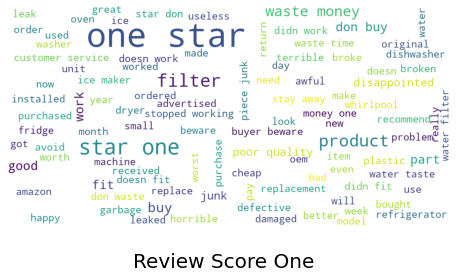

In [ ]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

In [ ]:
show_wordcloud(cluster1["summaryClean"][1], title = "Review Rating Two")

In [ ]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Rating Three")

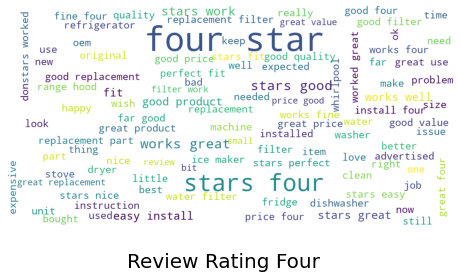

In [ ]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Rating Four")

In [ ]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Rating Five")

# 2. Sentiment Analysis using LSTM Neural Network

#### Import libraries

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import time 
from tensorflow.keras.layers import Dropout

In [ ]:
from keras.layers import Bidirectional

In [ ]:
from keras.layers import Activation

#### Load Data

In [ ]:
import pandas as pd
first500=pd.read_json('/content/drive/MyDrive/Appliances.json/Appliances.json',lines=True)


In [ ]:
data=first500[['summary','overall']]

In [ ]:
data.head()

summary  overall
0                  Clear on what leads to innovation        5
1  Becoming more innovative by opening yourself t...        5
2              The World from Different Perspectives        5
3                Strangers are Your New Best Friends        5
4  How and why it is imperative to engage, learn ...        5

In [ ]:
data['sentiment']= ['Positive' if x>=3 else 'Negative' for x in data['overall']]

In [ ]:
#function for cleaning summary
regEx = re.compile('[^a-z]+')
def cleanReviews(summary):
    summary = summary.lower()
    summary = regEx.sub(' ', summary).strip()
    return summary

In [ ]:
data = first500[['summary', 'overall']].astype(str)

In [ ]:
data["summaryClean"] = data["summary"].apply(cleanReviews)

In [ ]:
data.head()

summary  ...                                       summaryClean
0                  Clear on what leads to innovation  ...                  clear on what leads to innovation
1  Becoming more innovative by opening yourself t...  ...  becoming more innovative by opening yourself t...
2              The World from Different Perspectives  ...              the world from different perspectives
3                Strangers are Your New Best Friends  ...                strangers are your new best friends
4  How and why it is imperative to engage, learn ...  ...  how and why it is imperative to engage learn f...

[5 rows x 3 columns]

In [ ]:
data['length']=data['summaryClean'].apply(lambda x: len(x.split()))

In [ ]:
data.head()

summary  ... length
0                  Clear on what leads to innovation  ...      6
1  Becoming more innovative by opening yourself t...  ...     10
2              The World from Different Perspectives  ...      5
3                Strangers are Your New Best Friends  ...      6
4  How and why it is imperative to engage, learn ...  ...     14

[5 rows x 4 columns]

In [ ]:
data['length'].max()

67

#### WordTokenizer

In [ ]:
#I have considered a rating equal or above 3 as positive and less than 3 as negative.

tokenizer = Tokenizer(num_words=2500, lower=True,split=' ') #creating an instance of Toekenizer for top 2500 words.
tokenizer.fit_on_texts(data['summaryClean'].values)# Creating dictionary of words as per thein frequency 

#print(tokenizer.word_index)  # To see the dictionary

X2 = tokenizer.texts_to_sequences(data['summaryClean'].values) # converting words to sequence of related numbers
X2 = pad_sequences(X,padding='post') #making all summary of equal lengths
Y2 = pd.get_dummies(data['sentiment']).values #converting sentiments using one hot encoding

#train test split
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid = train_test_split(X2,Y2, test_size = 0.20, random_state = 36)

KeyError: ignored

In [ ]:
X2.shape

(6919, 300)

### Model

In [ ]:

batch_size = 32

model2 = Sequential()
model2.add(Embedding(2500, 100,input_length = X2.shape[1]))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout= 0.2, recurrent_dropout = 0.2,return_sequences=True))
model2.add(LSTM(64, dropout= 0.2, recurrent_dropout = 0.2,return_sequences=True))
model2.add(Bidirectional(LSTM(32,activation='relu')))
model2.add(Dense(2,activation='softmax'))
model2.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          250000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 300, 100)          80400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 64)           42240     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 397,602
Trainable params: 397,602
Non-trainable params: 0
__________________________________________________

In [ ]:
history_model2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_valid,Y_valid), verbose=2)

NameError: ignored

### Model 2 with epochs=2 has been selected and now being trained 

In [ ]:
model2.fit(X_train, Y_train, batch_size =batch_size, epochs =2,  verbose = 2)

In [ ]:
loss2,acc2=model2.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
print(f"loss {loss2} and accuracy is {acc2}")

### Testing model2 with Unseen Data of 100k

---



In [ ]:
unseen=pd.read_json('unseenamazon.json',lines=True)

In [ ]:
unseen=unseen[['summary','overall']]

In [ ]:
unseen['sentiment']= ['Positive' if x>=3 else 'Negative' for x in unseen['overall']]

In [ ]:
unseen["summaryClean"] = unseen["summary"].apply(cleanReviews)

In [ ]:
unseen.head()

In [ ]:
tokenizer = Tokenizer(num_words=2500, lower=True,split=' ')
tokenizer.fit_on_texts(unseen['summaryClean'].values)
#print(tokenizer.word_index)  # To see the dictionary
X_unseen = tokenizer.texts_to_sequences(unseen['summaryClean'].values)
X_unseen = pad_sequences(X_unseen)

In [ ]:
Y_unseen = pd.get_dummies(unseen['sentiment']).values

In [ ]:
loss2,acc2=model2.evaluate(X_unseen,Y_unseen,verbose=2,batch_size=batch_size)
print(f"loss {loss2} and accuracy is {acc2}")

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
plot_graphs(history_model2, "accuracy")
plot_graphs(history_model2, "loss")

# 3. Recommenders!! ( Content Based)

In [ ]:
required_metadata=pd.read_csv('required_metadata_amazon.csv')
required_metadata.head()

In [ ]:
required_metadata.shape

In [ ]:
required_metadata.info()

In [ ]:
#Select required columns
meta=required_metadata[['asin','title','feature']]

In [ ]:
meta.head()

In [ ]:
#Make feature column of type string
meta['feature']=meta['feature'].astype('str')


In [ ]:
meta.head()

In [ ]:
# import require library
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
#create an instance of the TfidfVectorizer
tvf=TfidfVectorizer(min_df=3,strip_accents='unicode',analyzer='word',ngram_range=(1,3))

In [ ]:
#fill any Nan values in feature item
meta['feature']=meta['feature'].fillna('')

In [ ]:
#tvf matrix for features of different products
tvf_matrix=tvf.fit_transform(meta['feature'])

In [ ]:
tvf_matrix.shape

In [ ]:
#import sigmoid kernel for similarity matrix between products
from sklearn.metrics.pairwise import sigmoid_kernel

In [ ]:
#create similarity matrix
sig=sigmoid_kernel(tvf_matrix,tvf_matrix)

In [ ]:
#checking first product similarity with others
sig[0]

In [ ]:
#creating a series to keep track of the titles of the products.
indices=pd.Series(meta.index,index=meta['title'])

In [ ]:
#testing
print(indices[:4],'\n')

### Gives recommendation on any clicked product

In [ ]:
#Function that gives recommendation based on similarity of features.
def give_recommendation (title,sig=sig):
    
    #get the index of the product (title) from indices series
    idx=indices[title]
    
    #Look for this index in sig similarity matrix
    sig_score=list(enumerate(sig[idx]))
    
    #sort the obtained row for most related product on top
    sig_score=sorted(sig_score,key=lambda x: x[1],reverse=True)
    
    #Get top 5 products information
    sig_score=sig_score[1:6]
    
    #get the list of indices with first column of sig_score
    product_idx=[i[0] for i in sig_score]
    
    #put this list in the main dataset to get the titles of most similar products.
    return meta['title'].iloc[product_idx]

In [ ]:
give_recommendation('Rand McNally 528881469 7-inch Intelliroute TND 700 Truck GPS')